In [1]:
import pickle
import sys

import numpy as np
import optuna
import pandas as pd
from scipy.stats import qmc
from sklearn.model_selection import cross_val_score

sys.path.append('../src')

import matplotlib.pyplot as plt
import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from utils import plot_pca
from xgboost import XGBRegressor



In [2]:
# No. of input variables (features)
user_params = {"dim": 10}

input_vars = ["x_" + str(i) for i in range(1, user_params["dim"] + 1)]
response_vars = ["y"]

# Define no. of instances for the initial DBTL cycle
user_params["n_instances_cycle1"] = 100
# Define the no. of cycles to perform
user_params["num_recommendations"] = 16
# Define the objective for optimization and a threshold for defining success (for example, a success is 20% improvement over the best in the training data set)
user_params["objective"] = "maximize"
user_params["threshold"] = 0.2


### Define true response function

In [3]:
def true_function_medium(x, dimension):
    f = 0.0
    for i in range(dimension):
        f += x[i] ** 4 - 16 * x[i] ** 2 + 5 * x[i]

    f *= 1 / dimension
    return -1.0 * f


In [4]:
dim = user_params["dim"]
global_optimum_value = 78.332
global_optimum = -2.903534 * np.ones(dim)
lb, ub = -5.0, 5.0


#### Define constraints on the input variables

In [5]:
bounds = pd.DataFrame(columns=["Variable", "Min", "Max", "Scaling"])
bounds["Variable"] = ["x_" + str(i) for i in range(1, dim + 1)]
bounds["Min"] = lb * np.ones(dim)
bounds["Max"] = ub * np.ones(dim)
bounds["Scaling"] = np.ones(dim)
bounds = bounds.set_index("Variable")


## Cycle 1

In [6]:
cycle = 1


In [7]:
def create_initial_cycle_data(bounds: pd.DataFrame, user_params: dict) -> pd.DataFrame:
    """ Generate data for initial design

    Args:
        bounds (pd.DataFrame)
        user_params (dict)

    Returns:
        pd.DataFrame
    """
    sampler = qmc.LatinHypercube(d=user_params["dim"])
    sample = sampler.random(n=user_params["n_instances_cycle1"])
    sample = qmc.scale(sample, bounds["Min"].values, bounds["Max"].values)

    X_initial = pd.DataFrame(sample, columns=input_vars)
    y_initial = true_function_medium(X_initial.values.T, dim).reshape(-1, 1)

    df = pd.DataFrame(
        np.hstack((X_initial, y_initial)), columns=input_vars + response_vars
    )
    return df


In [9]:
# Read cycle 1 data from ART paper
df = pd.read_csv("../data/simulated/sim_data_FM_cycle1.csv")

cols = df["Type"].unique()
idx = df["Line Name"].unique()

data = pd.DataFrame(columns=cols, index=idx)

for i in idx:
    for j in cols:
        data.loc[i, j] = df[(df["Line Name"] == i) & (df["Type"] == j)]["Value"].values[
            0
        ]

data = data.astype(float)

X = data.drop("y", axis=1)
y = data["y"]

print(data.shape)
data.head()

(16, 11)


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,-0.032122,4.887471,-4.421894,2.246075,0.844141,-3.075349,-2.437291,3.391681,3.832296,4.385524,-10.933652
1,1.446227,-0.810291,4.156549,4.829511,2.596708,-2.102342,3.002048,1.695751,2.917457,-0.726561,4.747164
2,2.160786,-0.101777,-4.246623,-0.742786,4.144502,-3.555235,-4.971381,3.983179,-4.705956,-2.790893,-18.409787
3,3.211198,-4.024549,1.363938,-1.938932,1.940373,3.118933,3.140141,-1.604126,3.229359,4.051867,31.875964
4,4.081553,-2.358454,-0.140108,-2.681768,-1.382352,1.757978,1.793158,-0.375667,-3.022229,2.705850,34.526840


In [10]:
print(data['y'].describe())

count    16.000000
mean      8.807802
std      18.799349
min     -18.409787
25%      -3.274486
50%       4.354880
75%      20.238861
max      42.175907
Name: y, dtype: float64


In [83]:
# Train and tune an XGBoost model using optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda',1e-4, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_jobs': -1,
        'random_state': 42
    }
    
    xgb = XGBRegressor(**params)
    scores = cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Train the model on the entire dataset
params = study.best_trial.params
xgb_model = XGBRegressor(**params)
xgb_model.fit(X, y)


[I 2024-01-09 14:34:51,625] A new study created in memory with name: no-name-2f77a72d-56c7-413c-98c9-c78d553a1a8a
[I 2024-01-09 14:34:55,572] Trial 0 finished with value: 20.263106643776496 and parameters: {'n_estimators': 7, 'max_depth': 14, 'learning_rate': 0.006388154996422026, 'subsample': 0.7666019089275917, 'colsample_bytree': 0.9829081486089722, 'gamma': 0.8738245651959783, 'reg_alpha': 0.015837765920425243, 'reg_lambda': 0.09492855531098947, 'min_child_weight': 3}. Best is trial 0 with value: 20.263106643776496.
[I 2024-01-09 14:34:57,023] Trial 1 finished with value: 3.3594091012412445e+21 and parameters: {'n_estimators': 33, 'max_depth': 17, 'learning_rate': 5.220467877967714, 'subsample': 0.8439239609403333, 'colsample_bytree': 0.5079678853398226, 'gamma': 0.8480359661699665, 'reg_alpha': 0.00014356270102552243, 'reg_lambda': 0.025685803277776847, 'min_child_weight': 9}. Best is trial 0 with value: 20.263106643776496.
[I 2024-01-09 14:34:58,423] Trial 2 finished with value: 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6177248353801276, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0869402906800337, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0832978679748477, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=75, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

RMSE = 14.355
STD = 111.034


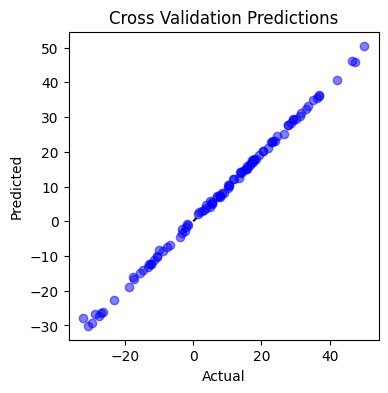

In [86]:
# Cross validate model on the data
def train(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    print(f'RMSE = {np.round(np.sqrt(np.abs(scores.mean())),4)}')
    print(f'STD = {np.round(scores.std(),4)}')
    model.fit(X, y)
    return model

def plot_R2(model, X, y):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(y, model.predict(X), color='blue', alpha=0.5)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Cross Validation Predictions')
    plt.show()

xgb = train(xgb_model, X, y)
plot_R2(xgb, X, y)

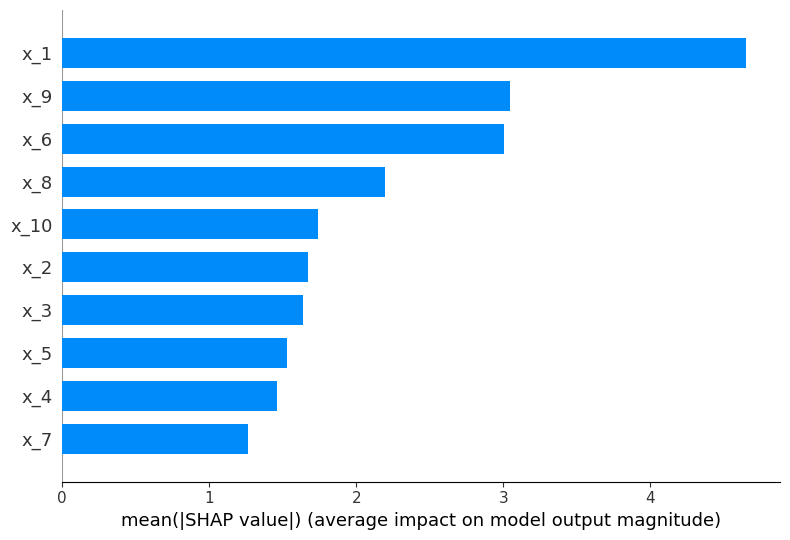

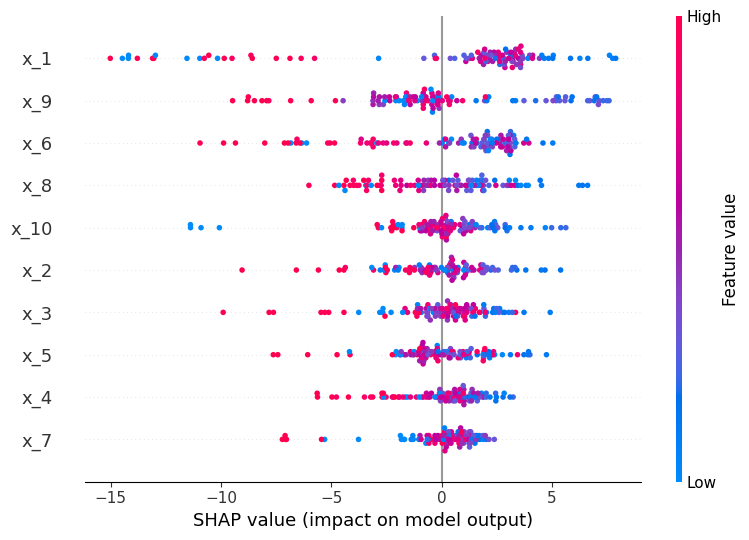

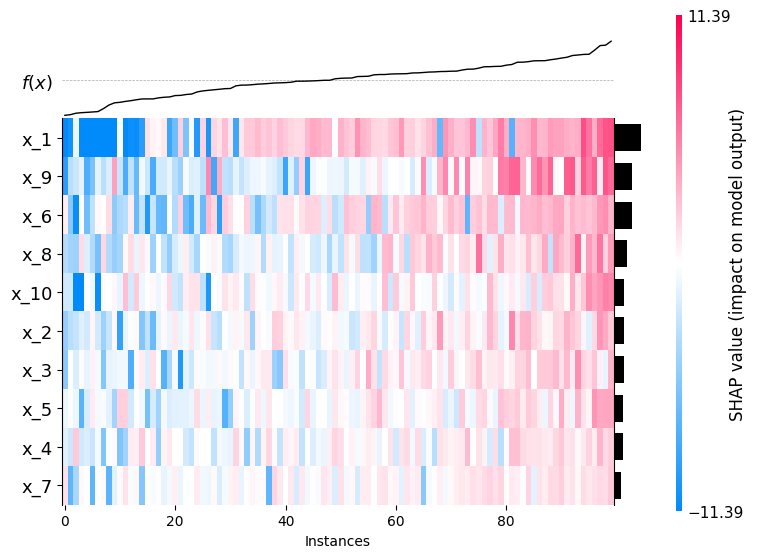

In [88]:
def shap_plots(model, X):
    # Calculate SHAP values and plot
    explainer = shap.TreeExplainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type='bar')
    shap.summary_plot(shap_values, X, plot_type='dot')
    order = np.argsort(model.predict(X))
    shap.plots.heatmap(shap_values, instance_order=order)
    return explainer, shap_values

explainer, shap_values = shap_plots(xgb, X)
# Shap values to dataframe
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df.index = data.index

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

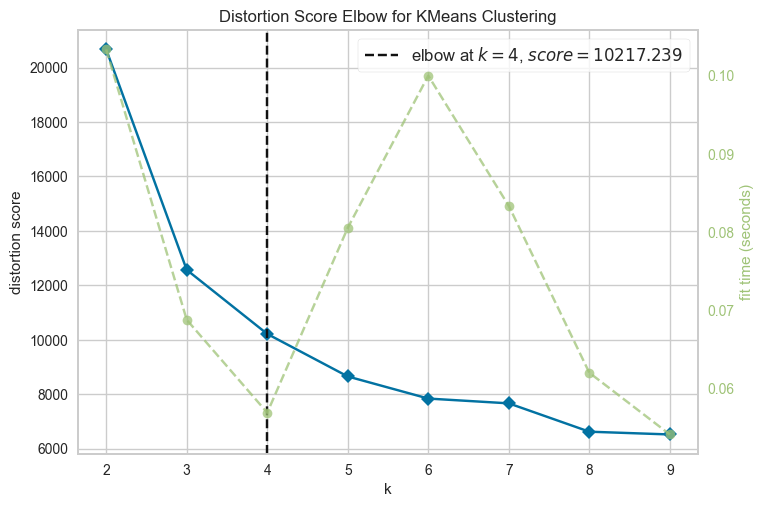

Optimal number of clusters = 4


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


In [92]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(shap_df)
visualizer.show()

# Get optimal number of clusters
n_clusters = visualizer.elbow_value_
print(f'Optimal number of clusters = {n_clusters}')

kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(shap_df)
shap_df['Cluster'] = kmeans.labels_
shap_df['y'] = data['y']

In [93]:
data['Cluster'] = shap_df['Cluster']
# groupy by cluster and calculate most common values
print('MOST COMMON VALUES')
display(data.groupby('Cluster').agg(lambda x:x.value_counts().index[0]))
# groupy by cluster and calculate mean values
print('MEAN VALUES')
display(data.groupby('Cluster').mean())
# groupy by cluster and calculate std values
print('STD VALUES')
display(data.groupby('Cluster').std())
# groupy by cluster and calculate median values
print('MEDIAN VALUES')
display(data.groupby('Cluster').median())

MOST COMMON VALUES


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
Cluster,,,,,,,,,,,
0,-4.641306,3.370174,-0.338817,-1.346855,3.550593,4.338095,1.282435,-4.519559,4.390240,-2.820407,-13.161093
1,2.656574,1.593443,1.428944,2.744410,3.638727,-4.501888,-3.167177,1.901368,-0.965248,3.834548,23.155970
2,0.132521,-4.641905,-1.209759,3.641483,4.187513,-2.239168,-2.651387,-1.142314,4.562565,1.485057,-3.172559
3,2.271472,2.717690,-1.828395,2.409442,-3.565735,-0.433822,2.464979,1.612596,-1.153602,-3.491773,42.187514


MEAN VALUES


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
Cluster,,,,,,,,,,,
0,0.157951,1.550899,0.590269,0.884544,-0.051887,1.205046,1.029875,0.137767,0.918837,-0.657634,-21.722380
1,-0.319345,0.196075,0.082514,-0.135416,0.036188,-0.364038,-0.521238,-0.224538,-0.239469,0.623774,15.853246
2,0.558591,-0.655955,-0.059881,0.132503,0.402238,0.442640,-0.015967,0.669950,0.409422,0.321096,-1.178598
3,-0.405457,-0.703730,-0.563667,-0.680486,-0.632146,-0.992210,0.132401,-0.715035,-0.952254,-1.118818,34.788698


STD VALUES


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
Cluster,,,,,,,,,,,
0,4.417439,3.015529,2.836666,3.191761,3.367613,2.782729,3.213941,3.821056,3.332736,3.629259,7.348645
1,2.550336,3.019242,2.787827,3.025375,2.844303,2.716038,2.853786,3.066007,2.715576,2.686125,4.832038
2,2.453195,2.755912,3.142434,2.972809,2.879621,3.393369,2.975914,2.319815,3.073344,2.804219,6.532453
3,2.668948,2.395990,2.900529,2.227931,2.758733,2.157043,2.572900,2.445970,2.410807,2.516425,7.127976


MEDIAN VALUES


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
Cluster,,,,,,,,,,,
0,0.995193,2.799755,0.181473,2.066158,-0.073996,1.737856,1.154626,0.215278,1.538648,-1.663683,-21.055854
1,-0.622710,0.895794,0.817492,0.482570,0.274430,-0.474948,-0.524806,-0.206562,0.444784,1.010482,15.728941
2,0.312039,-0.830799,-0.619159,-0.438720,0.822608,0.523148,-0.106570,0.737472,0.460245,-0.045970,-1.505741
3,-0.292989,-1.410444,-1.518259,-1.040515,-1.649848,-1.599312,-0.364510,-0.283180,-1.624882,-1.855720,33.026635


In [96]:
data[data['Cluster'] == 3].sort_values(by='y', ascending=False)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y,Cluster
39,-3.656026,-1.410444,3.688327,-3.441930,-2.664878,-1.599312,-1.707137,-3.472636,-1.243339,-2.540309,50.229613,3
87,-3.213780,-2.985878,4.313218,-2.394976,-3.670062,-2.978129,-2.479555,-3.280483,3.376653,-4.080335,47.503500,3
44,-3.926257,-3.151682,3.873437,-1.040515,-3.201055,-3.513534,1.501620,-1.533648,-2.448942,-2.397503,46.565128,3
0,2.271472,2.717690,-1.828395,2.409442,-3.565735,-0.433822,2.464979,1.612596,-1.153602,-3.491773,42.187514,3
23,-3.354042,-4.091543,-1.518259,3.533931,-2.076557,0.727149,-0.364510,2.096530,-2.557001,-1.559759,36.884545,3
72,-4.159811,3.954028,1.080543,-2.227540,3.445418,0.330722,3.047849,-3.077017,-2.815488,-2.438487,36.825211,3
94,-1.411541,-0.764918,-3.519098,3.289794,3.123374,1.933197,1.946534,-3.342571,3.606145,0.658835,36.280407,3
64,-0.292989,-2.276252,-1.409082,0.597469,0.025117,-2.065492,-0.903028,1.581838,-2.383932,-3.322295,35.270522,3
61,-0.531613,-2.576185,-3.893298,0.822432,-1.026113,-3.910263,3.565810,-2.282650,-1.356616,2.089038,33.663021,3
16,1.904500,2.063138,1.139191,-3.163860,-2.972136,1.821871,-1.370006,-0.283180,-0.543781,-0.715909,33.026635,3
